
# American-Style Option Pricing via Kernel Regression (FALKON)

This notebook prices path-independent American-style options (e.g., max-call, geometric-basket put) in a **multi-asset GBM** setting via **backward induction** using **FALKON** (Nyström preconditioned kernel ridge regression).

**Highlights**
- Modular utilities for simulation (correlated GBM), payoffs, and continuation-value Monte Carlo.
- Clean model-selection loop over kernel scales (`lengthscale`) and penalties (`alphas`).
- Robust timing, reproducibility, and confidence-interval reporting over multiple repeats.
- Optional 2D visualization panel (saved as `value_function_panel.pdf`), separated in its own cell.
- A simple **hindsight upper bound** diagnostic based on per-path best exercise time.

> Tip: Run the notebook top-to-bottom. The compute-heavy cell is the Backward Induction & Training cell.


## 1. Environment & Imports

In [1]:

# Reproducible environment & informative versions
import os, sys, time, math, warnings, platform, random
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, Optional

import numpy as np
import torch

# Strictly use Matplotlib for plots (no seaborn)
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (registers 3D projection)

from scipy.stats import norm

try:
    from falkon import Falkon
    from falkon.kernels import GaussianKernel
    from falkon.options import FalkonOptions
    import falkon.utils.devices
except Exception as e:
    warnings.warn("FALKON not found or import failed. Install with `pip install falkon`.", ImportWarning)
    raise

# Make Falkon stop probing unavailable devices in some environments
# (harmless no-op if attribute not present)
try:
    falkon.utils.devices.__COMP_DATA = {}
except Exception:
    pass

np.set_printoptions(precision=4, suppress=True)
torch.set_default_dtype(torch.float64)

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Python: {platform.python_version()}  NumPy: {np.__version__}  PyTorch: {torch.__version__}")
try:
    import falkon
    print(f"FALKON: {falkon.__version__}")
except Exception:
    pass


Python: 3.12.11  NumPy: 2.1.2  PyTorch: 2.7.1+cu118
FALKON: 0.9.0+pt27cu118


## 2. Configuration

In [27]:

# --- Settings ---
@dataclass
class Config:
    cross_validation: bool = True   # simple grid-search split within each step
    plot_panels: bool = True         # only used if d == 2
    d: int = 2                       # number of assets
    use_cuda: Optional[bool] = True # auto-detect if None
    repeats: int = 10                 # number of independent runs for CI
    
    # Time-Grid & Market
    T: int = 9
    r: float = 0.05
    K: float = 100.0
    sigma_scalar: float = 0.2        # per-asset stdev if scalar; overridden by sigma if provided
    S0_scalar: float = 100.0         # per-asset initial spot if scalar
    delta_t: float = 1.0             # total time length
    n: int = 500                     # training samples at each step
    M: int = 150                     # MC samples for continuation value
    M_nystrom: int = 250             # Nyström centers
    
    # Kernel hyperparameters (gammas = 1/(2*l^2))
    alphas: Tuple[float, ...] = (1e-6, )
    lengthscales: Tuple[float, ...] = (40.,)
    
    # Correlation
    rho: float = 0.2                 # off-diagonal correlation

    # Payoff type: 'max_call' | 'geo_put'
    payoff_type: str = 'max_call'

CFG = Config()

# Derived quantities
dt = CFG.delta_t / CFG.T
sigma = np.ones(CFG.d) * CFG.sigma_scalar
S0 = np.ones(CFG.d) * CFG.S0_scalar

# Correlated covariance + Cholesky
rho_matrix = (1 - CFG.rho) * np.eye(CFG.d) + CFG.rho * np.ones((CFG.d, CFG.d))
cov = np.outer(sigma, sigma) * rho_matrix
L = np.linalg.cholesky(cov)

# Auto-detect CUDA if not specified
if CFG.use_cuda is None:
    CFG.use_cuda = torch.cuda.is_available()
print(f"CUDA available: {CFG.use_cuda}")


print("Config:", CFG)


CUDA available: True
Config: Config(cross_validation=True, plot_panels=True, d=2, use_cuda=True, repeats=10, T=9, r=0.05, K=100.0, sigma_scalar=0.2, S0_scalar=100.0, delta_t=1.0, n=500, M=150, M_nystrom=250, alphas=(1e-06,), lengthscales=(40.0,), rho=0.2, payoff_type='max_call')


## 3. Payoffs & GBM Utilities

In [28]:

def call_payoff(x: np.ndarray, K: float) -> np.ndarray:
    x = np.atleast_2d(x)
    return np.maximum(x[:, 0] - K, 0.0)

def max_call_payoff(x: np.ndarray, K: float) -> np.ndarray:
    x = np.atleast_2d(x)
    return np.maximum(np.max(x, axis=1) - K, 0.0)

def geometric_put_payoff(x: np.ndarray, K: float) -> np.ndarray:
    x = np.atleast_2d(x)
    # Guard log, then geometric mean
    geo_mean = np.exp(np.mean(np.log(np.maximum(x, 1e-12)), axis=1))
    return np.maximum(K - geo_mean, 0.0)

def make_payoff(kind: str, K: float) -> Callable[[np.ndarray], np.ndarray]:
    if kind == 'max_call':
        return lambda x: max_call_payoff(x, K) if x.shape[1] > 1 else call_payoff(x, K)
    elif kind == 'geo_put':
        return lambda x: geometric_put_payoff(x, K)
    else:
        raise ValueError(f"Unknown payoff_type: {kind}")

payoff = make_payoff(CFG.payoff_type, CFG.K)

def gbm_step_correlated(x: np.ndarray, dt: float, r: float, sigma: np.ndarray, L: np.ndarray) -> np.ndarray:
    """One correlated GBM step using Cholesky L of asset covariance."""
    z = np.random.randn(*x.shape)
    correlated_z = z @ L.T
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = correlated_z * math.sqrt(dt)
    return x * np.exp(drift + diffusion)

def simulate_continuation(x: np.ndarray,
                          V_next: Callable[[np.ndarray], np.ndarray],
                          r: float, dt: float,
                          sigma: np.ndarray, L: np.ndarray, M: int) -> np.ndarray:
    """Monte Carlo estimator of discounted continuation value E[e^{-r dt} V_{t+1}(X_{t+1}) | X_t=x]."""
    N = x.shape[0]
    vals = np.zeros(N)
    for i in range(N):
        x_next = np.tile(x[i], (M, 1))
        x_next = gbm_step_correlated(x_next, dt, r, sigma, L)
        vals[i] = np.mean(V_next(x_next))
    return np.exp(-r * dt) * vals

def sample_state_at_time(t: int, S0: np.ndarray, sigma: np.ndarray, r: float, dt: float, n: int, d: int) -> np.ndarray:
    """Sample X_t ~ LogNormal for GBM law at discrete time t."""
    jitter = 1.0 if t == 0 else 1e-6  # avoid zero variance at t=0
    drift = (r - 0.5 * sigma**2) * t * dt
    log_mean = np.log(S0) + drift
    return np.random.lognormal(mean=log_mean, sigma=sigma * np.sqrt(t * dt + jitter), size=(n, d))


## 4. FALKON Model Selection Helper

In [29]:

def fit_best_falkon(X: np.ndarray, Y: np.ndarray,
                    alphas: Tuple[float, ...],
                    lengthscales: Tuple[float, ...],
                    M_nystrom: int,
                    use_cuda: bool) -> Tuple[Falkon, Tuple[float, float]]:
    """Grid-search over (alpha, gamma) using a simple holdout split."""
    # Holdout split
    n = X.shape[0]
    idx = np.random.permutation(n)
    n_val = int(0.3 * n)
    val_idx = idx[:n_val]
    tr_idx = idx[n_val:]
    X_tr, Y_tr = X[tr_idx], Y[tr_idx]
    X_val, Y_val = X[val_idx], Y[val_idx]

    best_score = np.inf
    best_model = None
    best_params = (None, None)

    for alpha in alphas:
        for lengthscale in lengthscales:
            kernel = GaussianKernel(sigma=lengthscale)
            options = FalkonOptions(use_cpu=not use_cuda)
            model = Falkon(kernel=kernel, penalty=alpha, M=M_nystrom, options=options)
            model.fit(
                torch.from_numpy(np.atleast_2d(X_tr).astype(np.float64)),
                torch.from_numpy(Y_tr.astype(np.float64).reshape(-1, 1))
            )
            preds = model.predict(torch.from_numpy(np.atleast_2d(X_val).astype(np.float64)))
            preds_np = preds.cpu().numpy().reshape(-1)
            score = np.mean((preds_np - Y_val)**2)
            if score < best_score:
                best_score = score
                best_model = model
                best_params = (alpha, lengthscale)

    assert best_model is not None, "Model selection failed."
    return best_model, best_params


## 5. Plotting Utilities (2D case only)

In [36]:

def plot_value_surface(f_hat: Callable[[np.ndarray], np.ndarray],
                       X_grid: np.ndarray,
                       t_label: str,
                       ax: plt.Axes) -> None:
    X1_u = np.unique(X_grid[:, 0])
    X2_u = np.unique(X_grid[:, 1])
    X1, X2 = np.meshgrid(X1_u, X2_u)
    grid = np.c_[X1.ravel(), X2.ravel()]
    Z = f_hat(grid).reshape(X1.shape)
    surf = ax.plot_surface(X1, X2, Z, edgecolor='k', alpha=0.9, linewidth=0.3)
    ax.set_title(f"t = {t_label}", fontsize=12, fontweight='bold')
    ax.set_xlabel("$X_t^1$")
    ax.set_ylabel("$X_t^2$")
    ax.set_zlabel("$V_t(X)$")
    ax.view_init(elev=25, azim=135)

def save_value_panel(collected: Dict[int, Callable[[np.ndarray], np.ndarray]],
                     payoff_fn: Callable[[np.ndarray], np.ndarray],
                     S_range=(50, 150), points=30, filename="value_function_panel.pdf") -> None:
    if CFG.d != 2:
        print("Panel plotting is only implemented for d=2.")
        return
    grid = np.linspace(S_range[0], S_range[1], points)
    X_plot = np.array(np.meshgrid(grid, grid)).T.reshape(-1, 2)

    all_times = sorted(collected.keys()) + ['payoff']
    fig = plt.figure(figsize=(18, 10))
    for i, t_plot in enumerate(all_times):
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        if t_plot == 'payoff':
            plot_value_surface(lambda x: payoff_fn(np.atleast_2d(x)), X_plot, "T", ax)
        else:
            plot_value_surface(collected[t_plot], X_plot, str(t_plot), ax)
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300)
    plt.show()
    plt.close(fig)
    print(f"Saved panel to {filename}")


## 6. Hindsight Upper-Bound Diagnostic

In [37]:

def hindsight_max_exercise(S0: np.ndarray, T: int, dt: float, r: float,
                           sigma: np.ndarray, L: np.ndarray, K: float, n_paths: int = 1000,
                           payoff_fn: Callable[[np.ndarray], np.ndarray] = None) -> Tuple[float, float, float, float]:
    """
    For each path, compute the *best* exercise time in hindsight by maximizing the discounted payoff
    over t=0..T. Returns (mean payoff, se payoff, mean exercise time, se time).
    """
    if payoff_fn is None:
        payoff_fn = payoff
    disc = np.exp(-r * dt * np.arange(0, T + 1))

    # Simulate paths
    S_paths = np.tile(S0.reshape(1, -1), (n_paths, 1))
    payoffs = np.zeros(n_paths)
    t_star = np.zeros(n_paths)
    for i in range(n_paths):
        # build the whole path
        S_t = np.zeros((T + 1, S0.shape[0]))
        S_t[0] = S_paths[i]
        for t in range(T):
            S_t[t + 1] = gbm_step_correlated(S_t[t:t+1], dt, r, sigma, L)[0]
        # compute discounted payoffs
        P_t = payoff_fn(S_t)
        DP_t = disc * P_t
        idx = int(np.argmax(DP_t))
        payoffs[i] = DP_t[idx]
        t_star[i] = idx

    h_mean = np.mean(payoffs)
    h_se = np.std(payoffs, ddof=1) / math.sqrt(n_paths)
    t_mean = np.mean(t_star)
    t_se = np.std(t_star, ddof=1) / math.sqrt(n_paths)
    return h_mean, h_se, t_mean, t_se


## 7. Backward Induction & Training (Compute-Heavy)

In [32]:

final_estimates = []
selected_times = [0, 2, 4, 6, 8]  # to visualize, if d==2
start_all = time.time()

for run in range(CFG.repeats):
    print(f"\n--- Repetition {run + 1} / {CFG.repeats} ---")
    models: Dict[int, Callable[[np.ndarray], np.ndarray]] = {}
    collected_plots: Dict[int, Callable[[np.ndarray], np.ndarray]] = {}

    # Terminal condition
    V_hat = lambda x: payoff(np.atleast_2d(x))

    # Backward induction
    for t in reversed(range(CFG.T)):
        X = sample_state_at_time(t, S0, sigma, CFG.r, dt, CFG.n, CFG.d)
        Y_cont = simulate_continuation(X, V_hat, CFG.r, dt, sigma, L, CFG.M)
        Y = np.maximum(Y_cont, payoff(X))

        model, (alpha, lengthscale) = fit_best_falkon(
            X, Y,
            alphas=CFG.alphas,
            lengthscales=CFG.lengthscales,
            M_nystrom=CFG.M_nystrom,
            use_cuda=CFG.use_cuda
        )
        print(f"t={t:2d}  best alpha={alpha:.2e}  lengthscale={lengthscale:.2f}")

        # Wrap predictor
        def V_hat_factory(m: Falkon) -> Callable[[np.ndarray], np.ndarray]:
            def _call(x: np.ndarray) -> np.ndarray:
                x = np.atleast_2d(x).astype(np.float64)
                out = m.predict(torch.from_numpy(x))
                return out.detach().cpu().numpy().reshape(-1)
            return _call

        V_hat = V_hat_factory(model)
        models[t] = V_hat
        if CFG.d == 2 and t in selected_times:
            collected_plots[t] = V_hat

    # Price at t=0
    price_0 = models[0](S0.reshape(1, -1))[0]
    final_estimates.append(price_0)
    print(f"Estimated price at t=0: {price_0:.6f}")

end_all = time.time()
duration = end_all - start_all
print(f"\nTotal wall-clock time: {duration:.2f} seconds\n")



--- Repetition 1 / 10 ---
t= 8  best alpha=1.00e-06  lengthscale=40.00
t= 7  best alpha=1.00e-06  lengthscale=40.00
t= 6  best alpha=1.00e-06  lengthscale=40.00
t= 5  best alpha=1.00e-06  lengthscale=40.00
t= 4  best alpha=1.00e-06  lengthscale=40.00
t= 3  best alpha=1.00e-06  lengthscale=40.00
t= 2  best alpha=1.00e-06  lengthscale=40.00
t= 1  best alpha=1.00e-06  lengthscale=40.00
t= 0  best alpha=1.00e-06  lengthscale=40.00
Estimated price at t=0: 16.930870

--- Repetition 2 / 10 ---
t= 8  best alpha=1.00e-06  lengthscale=40.00
t= 7  best alpha=1.00e-06  lengthscale=40.00
t= 6  best alpha=1.00e-06  lengthscale=40.00
t= 5  best alpha=1.00e-06  lengthscale=40.00
t= 4  best alpha=1.00e-06  lengthscale=40.00
t= 3  best alpha=1.00e-06  lengthscale=40.00
t= 2  best alpha=1.00e-06  lengthscale=40.00
t= 1  best alpha=1.00e-06  lengthscale=40.00
t= 0  best alpha=1.00e-06  lengthscale=40.00
Estimated price at t=0: 16.940220

--- Repetition 3 / 10 ---
t= 8  best alpha=1.00e-06  lengthscale=40

## 8. Summary Statistics & Confidence Interval

In [33]:

final_estimates = np.array(final_estimates, dtype=float)
mean_price = float(np.mean(final_estimates))
std_error = float(np.std(final_estimates, ddof=1) / math.sqrt(max(1, len(final_estimates)))) if len(final_estimates) > 1 else 0.0
conf_level = 0.95
z = float(norm.ppf(1 - (1 - conf_level) / 2))
ci_low = mean_price - z * std_error
ci_high = mean_price + z * std_error

print("--- Final Estimate Summary ---")
print(f"Mean estimated price: {mean_price:.6f}")
print(f"Standard error: {std_error:.6f}")
print(f"{int(conf_level*100)}% Confidence interval: ({ci_low:.6f}, {ci_high:.6f})")


--- Final Estimate Summary ---
Mean estimated price: 17.013262
Standard error: 0.039410
95% Confidence interval: (16.936020, 17.090505)


## 9. Hindsight Diagnostic (Upper Bound)

In [38]:

h_mean, h_se, t_mean, t_se = hindsight_max_exercise(S0, CFG.T, dt, CFG.r, sigma, L, CFG.K, n_paths=1000, payoff_fn=payoff)
print("--- Hindsight Evaluation ---")
print(f"Mean payoff (hindsight upper bound): {h_mean:.6f} ± {1.96 * h_se:.6f}")
print(f"Mean exercise time (argmax): {t_mean:.3f} ± {1.96 * t_se:.3f}")


--- Hindsight Evaluation ---
Mean payoff (hindsight upper bound): 22.547609 ± 1.042669
Mean exercise time (argmax): 5.949 ± 0.178


## 10. (Optional) Visualization Panel (d=2)

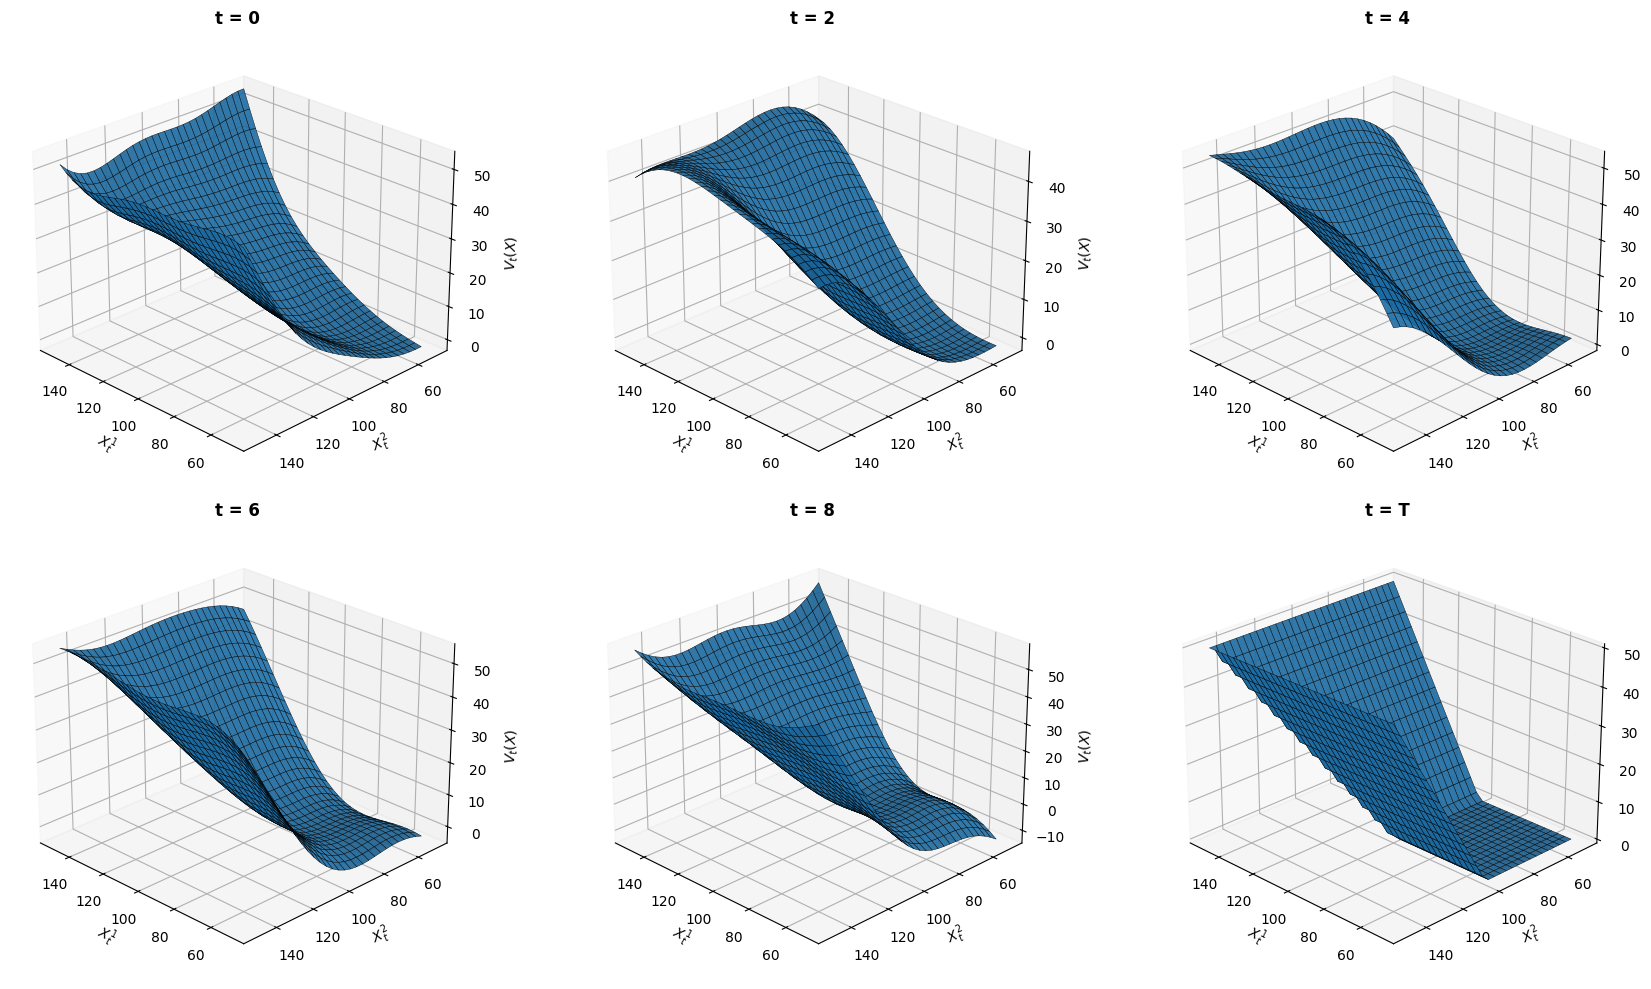

Saved panel to value_function_panel.pdf


In [39]:

if CFG.d == 2 and CFG.plot_panels:
    # Reuse the last run's collected models from the training cell
    try:
        save_value_panel(collected=collected_plots, payoff_fn=payoff, S_range=(50, 150), points=30, filename="value_function_panel.pdf")
    except NameError:
        print("No collected_plots found. Run the training cell first.")
else:
    print("Panel plotting skipped (either d != 2 or plotting disabled).\n")    



## Appendix: Notes & Possible Extensions

- **Cross-Validation**: The current grid-search uses a simple 70/30 hold-out at each step. You can easily extend to K-fold CV.
- **Exercise Strategy**: The current algorithm learns the value function; a separate policy extractor (e.g., exercise when payoff ≥ continuation) could be instrumented for analysis.
- **Path Dependence**: For path-dependent payoffs, extend the state to include sufficient statistics.
- **Scalability**: Tune `M_nystrom`, `n`, and `M` for performance/accuracy trade-offs. Leverage `use_cuda=True` if available.
- **Stability**: Ensure enough training variance at early times (`jitter`) and consider variance-reduction for MC (antithetic sampling, control variates).
